In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mlxtend as ml
import networkx as nx
import warnings

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules


warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

%matplotlib inline

## Hottest Products from another `.ipynb`
PRD0903052
PRD0903678
PRD0904358
PRD0900121
PRD0901265

In [2]:
df = pd.read_csv('supermarket_data.csv'); df.head()

,SHOP_DATE,SHOP_HOUR,BASKET_ID,CUST_CODE,STORE_CODE,PROD_CODE,QUANTITY,SPEND
0,20071006,21,994107800268406,CUST0000153531,STORE00001,PRD0901391,1,0.37
1,20070201,15,994104300305853,CUST0000219191,STORE00002,PRD0901915,1,5.08
2,20071103,13,994108200514137,CUST0000526979,STORE00003,PRD0903379,1,2.36
3,20070206,18,994104400743650,CUST0000913709,STORE00004,PRD0903305,1,0.20
4,20071015,19,994108000780959,CUST0000961285,STORE00001,PRD0903387,1,1.65


In [3]:
df.groupby(['BASKET_ID','PROD_CODE']).size().reset_index(name='counts')['counts'].max()

1

In [4]:
prods = df.groupby(['PROD_CODE']).agg(
    {'BASKET_ID': pd.Series.nunique}
).reset_index().rename(columns={'BASKET_ID': 'BASKET_COUNTS'})

In [5]:
prods.sort_values(by='BASKET_COUNTS', ascending=False)

,PROD_CODE,BASKET_COUNTS
3038,PRD0903052,15587
3661,PRD0903678,14508
4338,PRD0904358,12147
120,PRD0900121,8747
1259,PRD0901265,6225
...,...,...
4403,PRD0904423,1
554,PRD0900556,1
1806,PRD0901814,1
2122,PRD0902133,1


### Do seperately: SPLIT STORE 

In [6]:
basket = (df[df['STORE_CODE'] =="STORE00002"]
          .groupby(['BASKET_ID', 'PROD_CODE'])['QUANTITY']
          .sum().unstack().reset_index().fillna(0)
          .set_index('BASKET_ID'))

In [7]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)

In [8]:
basket_sets.head()

PROD_CODE,PRD0900001,PRD0900003,PRD0900004,PRD0900005,PRD0900006,PRD0900007,PRD0900008,PRD0900009,PRD0900011,PRD0900013,...,PRD0904987,PRD0904988,PRD0904989,PRD0904990,PRD0904991,PRD0904992,PRD0904993,PRD0904994,PRD0904995,PRD0904996
BASKET_ID,,,,,,,,,,,,,,,,,,,,,
994103900142079,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
994103900142080,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
994103900142081,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
994103900142082,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
994103900143715,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### **minimum support** is 0.01 since 0.005 give too much rules 
use `lift` as metric, then sort the table

In [9]:
frequent_itemsets = apriori(basket_sets, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift")
rules.sort_values('confidence', ascending = False, inplace = True)
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
5,(PRD0900239),(PRD0903052),0.020024,0.143020,0.010934,0.546053,3.818009,0.008070,1.887839
8,(PRD0901265),(PRD0903052),0.045712,0.143020,0.015720,0.343900,2.404555,0.009183,1.306173
14,(PRD0904250),(PRD0903678),0.032978,0.158345,0.010144,0.307590,1.942525,0.004922,1.215543
6,(PRD0900830),(PRD0903052),0.038818,0.143020,0.011900,0.306561,2.143480,0.006348,1.235840
12,(PRD0904358),(PRD0903052),0.095859,0.143020,0.021297,0.222171,1.553426,0.007587,1.101759
0,(PRD0900121),(PRD0903052),0.075923,0.143020,0.016818,0.221515,1.548839,0.005960,1.100831
10,(PRD0903052),(PRD0903678),0.143020,0.158345,0.031265,0.218606,1.380565,0.008618,1.077119
11,(PRD0903678),(PRD0903052),0.158345,0.143020,0.031265,0.197449,1.380565,0.008618,1.067819
16,(PRD0904358),(PRD0903678),0.095859,0.158345,0.016686,0.174072,1.099321,0.001508,1.019042
13,(PRD0903052),(PRD0904358),0.143020,0.095859,0.021297,0.148910,1.553426,0.007587,1.062333


Analyse the result:

**with confidence**
- 55% of the customers at STORE02 who bought *PRD0900239*, also bought *PRD0903052*

**with lift**
- The customers at STORE02 who bought *PRD0900239* are 4 times more likely to buy *PRD0903052*


and so on

In [10]:
r = rules[:10]
r['antecedents'] = r["antecedents"].apply(lambda x: list(x)[0]).astype("unicode")
r['consequents'] = r["consequents"].apply(lambda x: list(x)[0]).astype("unicode")

In [11]:
r.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
5,PRD0900239,PRD0903052,0.020024,0.143020,0.010934,0.546053,3.818009,0.008070,1.887839
8,PRD0901265,PRD0903052,0.045712,0.143020,0.015720,0.343900,2.404555,0.009183,1.306173
14,PRD0904250,PRD0903678,0.032978,0.158345,0.010144,0.307590,1.942525,0.004922,1.215543
6,PRD0900830,PRD0903052,0.038818,0.143020,0.011900,0.306561,2.143480,0.006348,1.235840
12,PRD0904358,PRD0903052,0.095859,0.143020,0.021297,0.222171,1.553426,0.007587,1.101759


In [12]:
rules['antecedents'][:10].values

array(['PRD0900239', 'PRD0901265', 'PRD0904250', 'PRD0900830',
       'PRD0904358', 'PRD0900121', 'PRD0903052', 'PRD0903678',
       'PRD0904358', 'PRD0903052'], dtype=object)

## Plot the product combination

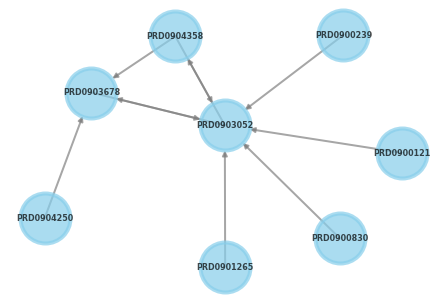

In [13]:
# Build your graph
G=nx.from_pandas_edgelist(r, 'antecedents', 'consequents', create_using=nx.DiGraph())
 
# Plot it
nx.draw(G, with_labels=True, 
        node_size=2500, node_color="skyblue", 
        node_shape="o", alpha=0.7, linewidths=4, 
        font_size=8, font_color="black", 
        font_weight="bold", width=2, edge_color="grey", arrows=True)

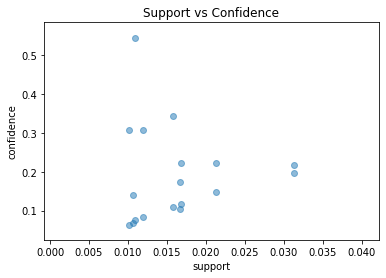

In [14]:
plt.scatter(rules['support'], rules['confidence'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('confidence')
plt.title('Support vs Confidence')
plt.show()

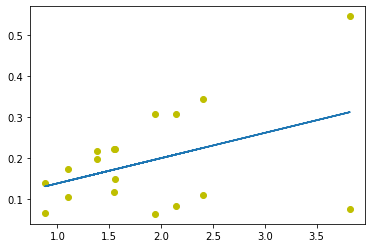

In [15]:
fit = np.polyfit(rules['lift'], rules['confidence'], 1)
fit_fn = np.poly1d(fit)
plt.plot(rules['lift'], rules['confidence'], 'yo', rules['lift'], 
 fit_fn(rules['lift']))